# KLMS Lorentz

Primera parte: imports

In [1]:
%matplotlib notebook
from numpy import *
import numpy as np
from scipy import *
import scipy.io as scio
from matplotlib import *
from pylab import *
import math as mt
import sys
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from KLMSv6 import KLMS_filter
rcParams['figure.figsize'] = 12, 8

Función para generar señal autorregresiva

In [2]:
def delaySignal(signal,delay):
    
    numRows = len(signal)
    numCols = len(signal[0])
    s = (numRows,delay,numCols-delay)    
    regresor = zeros(s)
    delayedSignal = signal[:,delay:numCols:1]
    for i in range(delay,numCols-1):
        regresor[:,:,i+1-delay] = signal[:,i-delay:i:1]
    return [delayedSignal,regresor]

Parámetros del ejemplo

In [3]:
## Parámetros de la simulación ##
simLength = 4000
sampleRes = 1
t = arange(0,simLength/sampleRes,1/sampleRes)
## Porcentaje de datos a mostrar el error ##
desiredPercent = 0.7
percentError = 1-desiredPercent
### Parámetros de KLMS ####
kernelWidth = 10
delay = 5
learningRate = 6e-2
sparsification = 0

Generación de la señal caótica de Lorenz discreta

In [4]:
######### Ejemplo sistema de Lorenz ########################################

x = zeros(len(t))
y = zeros(len(t))
z = zeros(len(t))

x[0] = 1 
y[0] = 1
z[0] = 1

sigmaL = 10
rhoL = 28
betaL = 8/3
sL = 0.01

for i in range(1,len(t)):
    x[i] = x[i-1] + sL * (sigmaL*(y[i-1] - x[i-1])) 
    y[i] = y[i-1] + sL * (x[i-1]*(rhoL - z[i-1]) - y[i-1])
    z[i] = z[i-1] + sL * (x[i-1]*y[i-1] - betaL*z[i-1])

#x = x/max(x)
#y = y/max(y)
#z = z/max(z)    

signal = [x,y,z]
#signal = [sin(t),cos(t),tan(t)]
signal = np.array(signal)
devChannel = 0.01
std_1 = devChannel
std_2 = devChannel
std_3 = devChannel

r1 = np.random.normal(0,std_1**2,len(t))
r2 = np.random.normal(0,std_2**2,len(t))
r3 = np.random.normal(0,std_3**2,len(t))

x_noise = x #+ r1
y_noise = y #+ r2
z_noise = z #+ r3
###########################################################################

## Construcción de señal autorregresiva ##
signal = [x,y,z]
signal = np.array(signal)

devChannel = 0.01
std_1 = devChannel
std_2 = devChannel
std_3 = devChannel

r1 = np.random.normal(0,std_1**2,len(t))
r2 = np.random.normal(0,std_2**2,len(t))
r3 = np.random.normal(0,std_3**2,len(t))

x_noise = x #+ r1
y_noise = y #+ r2
z_noise = z #+ r3

noiseSignal = [x_noise,y_noise,z_noise]

#noiseSignal = [sin(t) + r1,cos(t) + r2, tan(t) +r3]
noiseSignal = np.array(noiseSignal)

[signal,regSignalDummy] = delaySignal(signal,delay)
[noiseSignal,regSignal] = delaySignal(noiseSignal,delay)

noiseSignal = np.array(noiseSignal)
regSignal = np.array(regSignal)

Filtro KLMS

In [5]:
[filteredSignal,weights,centerList,MSE_KLMS,errorSignal,centerNum,presence,dictionaryComplexity,sigmaStory] = KLMS_filter(noiseSignal,regSignal,kernelWidth,delay,learningRate,sparsification)

Generación de plots de resultados

In [6]:
outputSignal = noiseSignal
inputSignal = regSignal
channelNum = len(signal)
accMSE = [0] * channelNum
accKLMS = [0] * channelNum
TN = len(noiseSignal[0])
accNaiveMSE = [0] * (TN-1)
s = (channelNum,TN-1)
naiveMSE = zeros(s)
s = (channelNum,TN)
KLMSMSE = zeros(s)



HOLO

In [7]:
for i in range(channelNum):
    accMSE[i] = sum(MSE_KLMS[i,percentError*TN:TN])
    naiveMSE[i,:] = (signal[i][1:TN] - noiseSignal[i][0:(TN-1)])**2
    KLMSMSE[i,:] = (signal[i][0:TN] - filteredSignal[i][0:TN])**2
    accKLMS[i] = sum(KLMSMSE[i,percentError*TN:TN])    
    accNaiveMSE[i] = sum(naiveMSE[i,percentError*TN:TN])    
    print("Error normalizado en el canal %s" %i)    
    #print(accMSE[i])
    #print("Otro error en el canal %s" %i)
    print(accKLMS[i]/simLength)
    print("Error normalizado naive en el canal %s" %i)
    print(accNaiveMSE[i]/simLength)

#logKLMS = np.log(KLMSMSE + 1)
#logNaive = np.log(naiveMSE + 1) 

Error normalizado en el canal 0
0.242909781215
Error normalizado naive en el canal 0
0.120984787698
Error normalizado en el canal 1
0.305790072627
Error normalizado naive en el canal 1
0.277520564192
Error normalizado en el canal 2
4.00803618392
Error normalizado naive en el canal 2
0.34918222171


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


HOLO 2

<IPython.core.display.Javascript object>


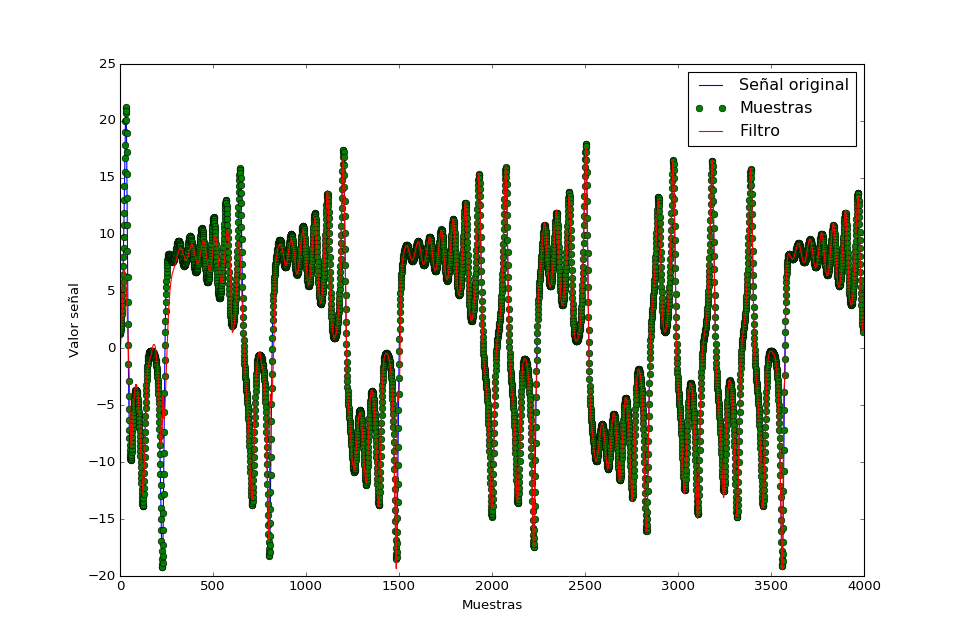

<IPython.core.display.Javascript object>


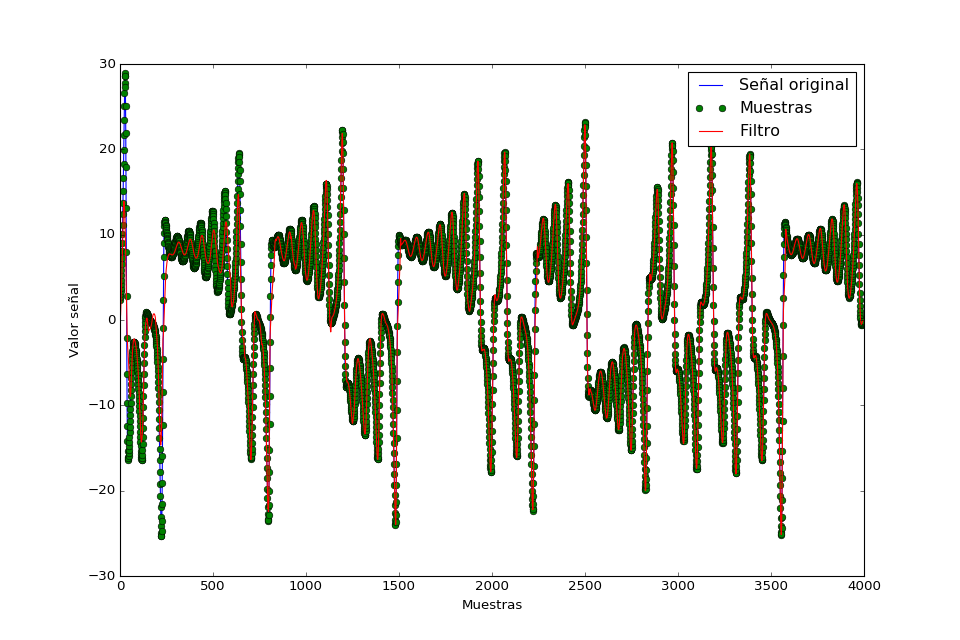

<IPython.core.display.Javascript object>


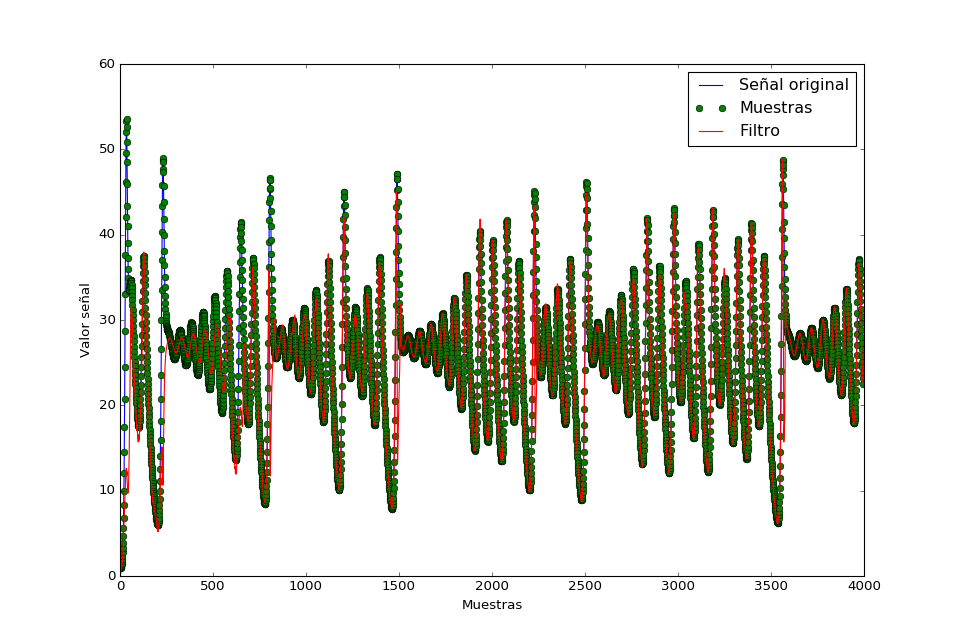

In [8]:
GraphLim = 1500
for i in range(len(signal)):
    figure(i)
    #signalMax = max(signal[i])
    #signalMin = min(signal[i])
    plot(t[0:len(t)-delay],signal[i][0:len(t)-delay],'blue', label ="Señal original")    
    plot(t[0:len(t)-delay],noiseSignal[i][0:len(t)-delay],'go', label ="Muestras")
    plot(t[0:len(t)-delay],filteredSignal[i][0:len(t)-delay],'red', label ="Filtro")
    #plot(t[0:GraphLim],signal[i][0:GraphLim],'blue', label ="Señal original")    
    #plot(t[0:GraphLim],noiseSignal[i][0:GraphLim],'go', label ="Muestras")
    #plot(t[0:GraphLim],filteredSignal[i][0:GraphLim],'red', label ="Filtro")
    #axis([0, TN/sampleRes, 1.2*signalMin, 1.2*signalMax])
    ylabel('Valor señal')
    xlabel('Muestras')
    legend()
    #grid() 

HOLO 3

<IPython.core.display.Javascript object>


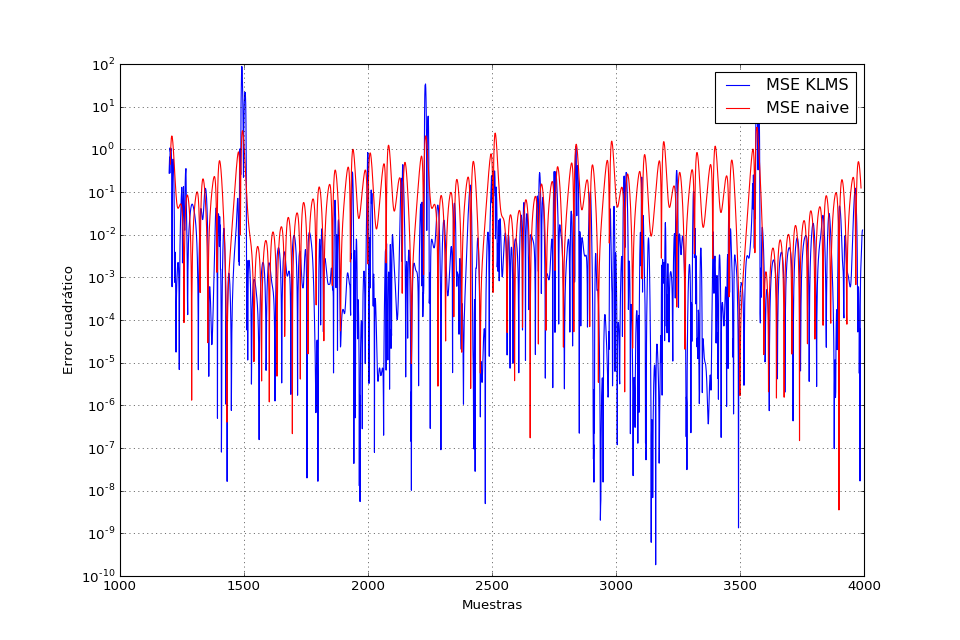

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


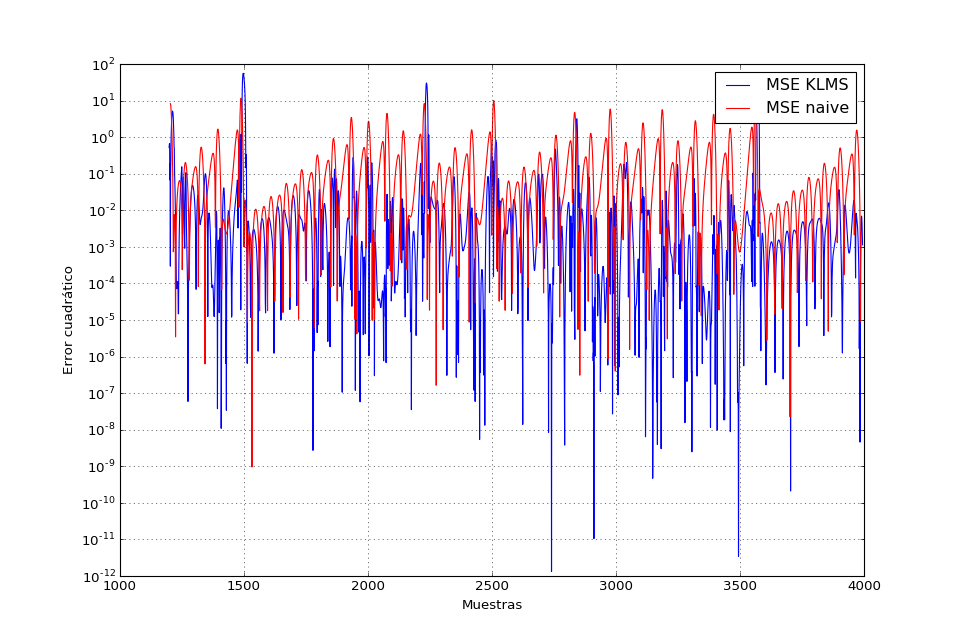

<IPython.core.display.Javascript object>


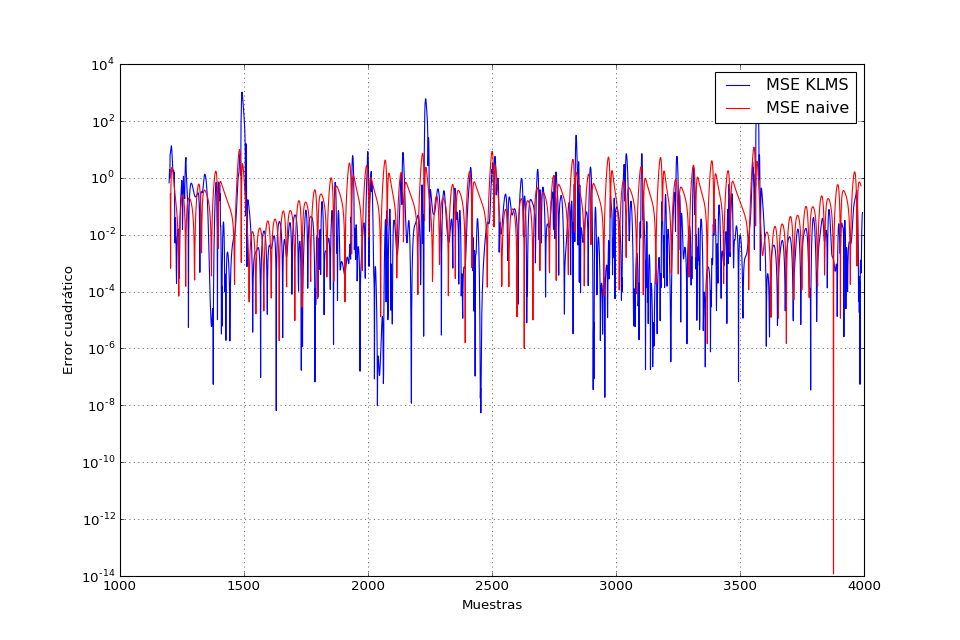

In [9]:
for i in range(len(signal)):
    figure(i+len(signal))
    semilogy(t[TN*percentError:len(t)-delay],KLMSMSE[i][TN*percentError:len(t)-delay],'blue', label ="MSE KLMS")
    #plot(t[TN*percentError:len(t)-delay],logKLMS[i][TN*percentError:len(t)-delay],'blue', label ="MSE KLMS")
    semilogy(t[TN*percentError+delay:len(naiveMSE[i])-delay],naiveMSE[i][TN*percentError+delay:len(naiveMSE[i])-delay],'red', label ="MSE naive")
    #plot(t[TN*percentError+delay:len(logNaive[i])-delay],naiveMSE[i][TN*percentError+delay:len(naiveMSE[i])-delay],'red', label ="MSE naive")    
    ylabel('Error cuadrático')   
    xlabel('Muestras')    
    legend()
    grid() 

HOLO 4

<IPython.core.display.Javascript object>


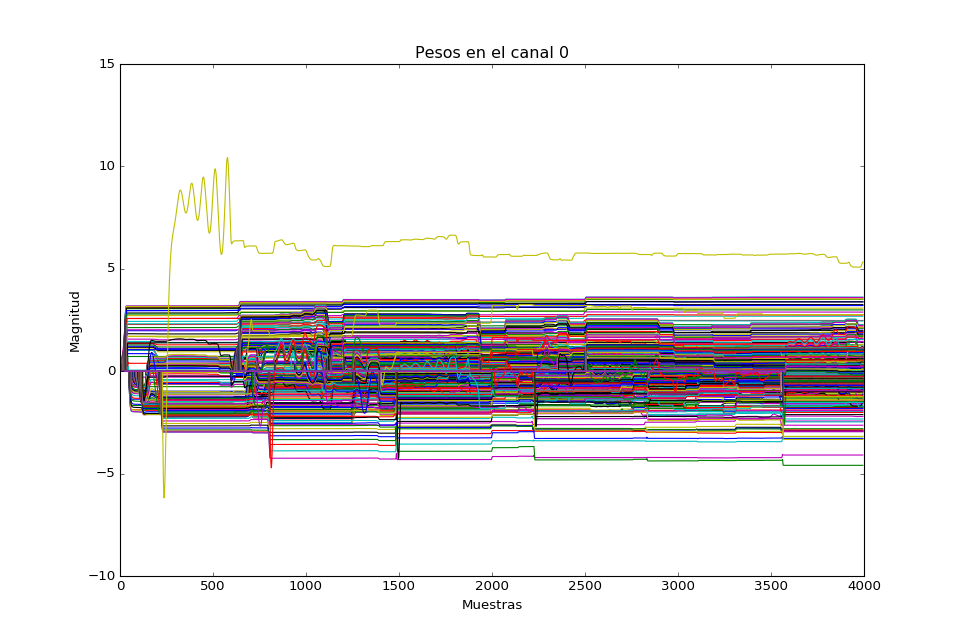

<IPython.core.display.Javascript object>


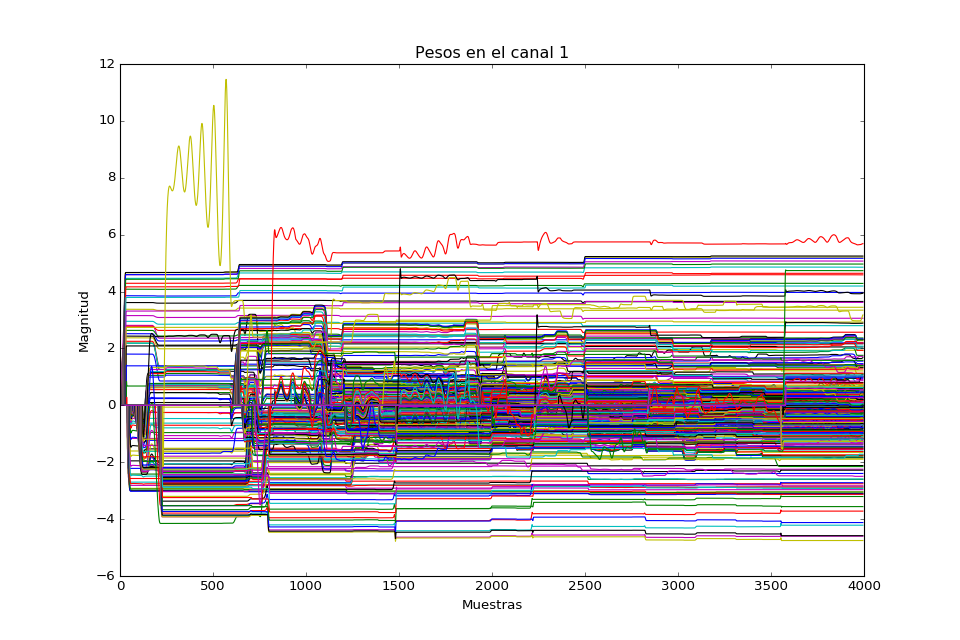

<IPython.core.display.Javascript object>


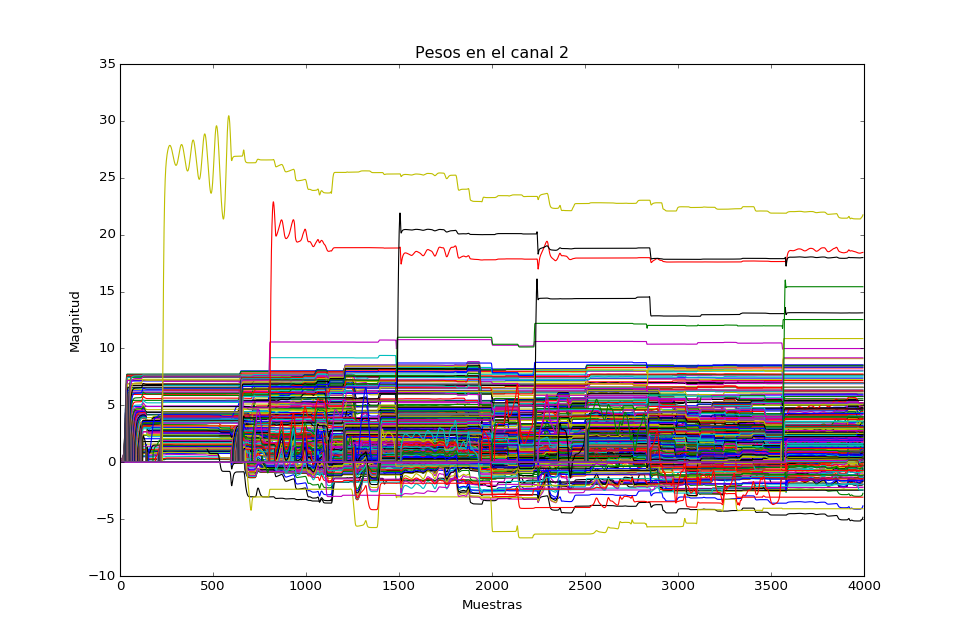

In [10]:
for i in range(channelNum):

    figure(i+2*len(signal))
    #limSup = len(weights[i,0,:])
    #centerlen(weights[i,:,0])
    intervalMax = 4000
    if TN < intervalMax:
        for j in range(centerNum):
                plot(t[0:TN],weights[i,j,:])
    else:
        for j in range(centerNum):
#            print(len(t[limSup-4000:limSup]))
#            print(len(weights[i,j,limSup-4000:limSup]))
            plot(t[TN-intervalMax:TN],weights[i,j,TN-intervalMax:TN])
    #weigthsLimMax = max(weights[i,:,:])
    #weigthsLimMin = min(weights[i,:,:])
    title("Pesos en el canal %s" %i)
    ylabel('Magnitud')   
    xlabel('Muestras')    
    #axis([0, TN/sampleRes, weigthsLimMin, weigthsLimMax])
    #legend()
    #grid() 

HOLO 5

<IPython.core.display.Javascript object>


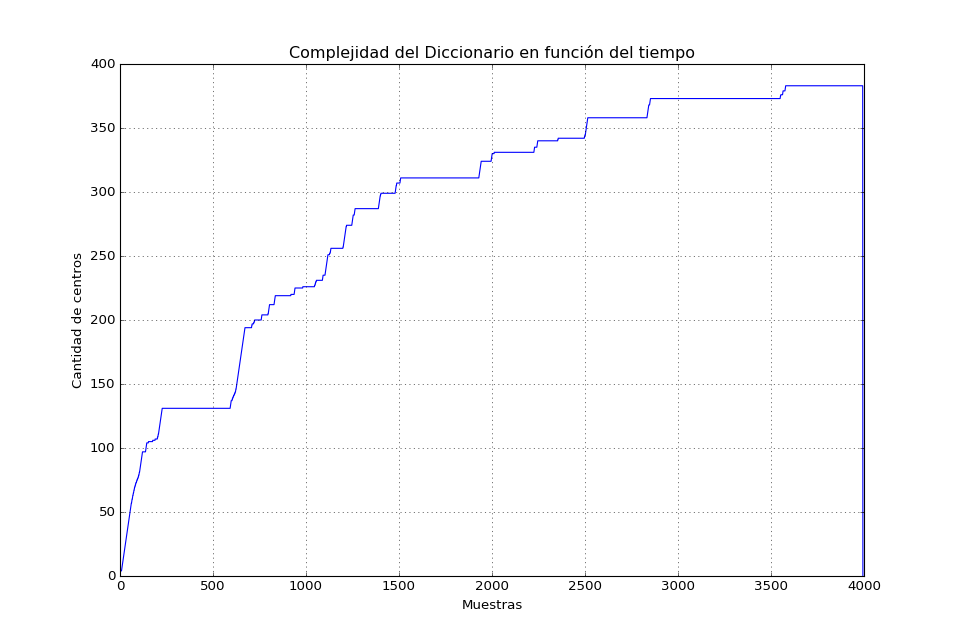

In [11]:
figure(9)
plot(t[0:simLength-delay],dictionaryComplexity)
title("Complejidad del Diccionario en función del tiempo")
ylabel('Cantidad de centros')   
xlabel('Muestras')    
grid()

HOLO 6

<IPython.core.display.Javascript object>


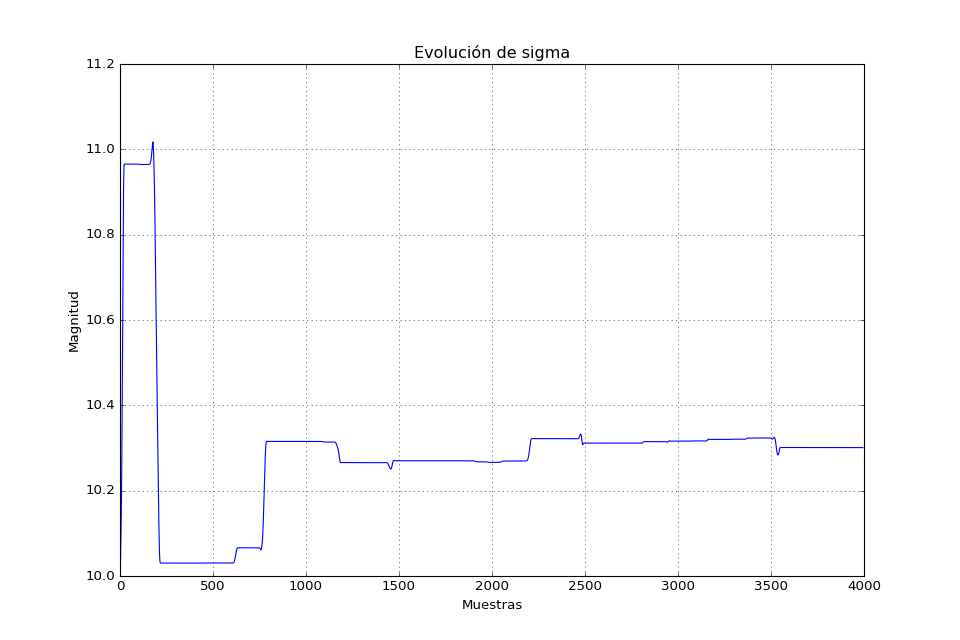

In [12]:
figure(10)
plot(t[0:len(dictionaryComplexity)],sigmaStory)
#plot(t[0:GraphLim],sigmaStory[0:GraphLim])
title("Evolución de sigma")
ylabel('Magnitud')   
xlabel('Muestras')   
grid() 

HOLO 7

<IPython.core.display.Javascript object>


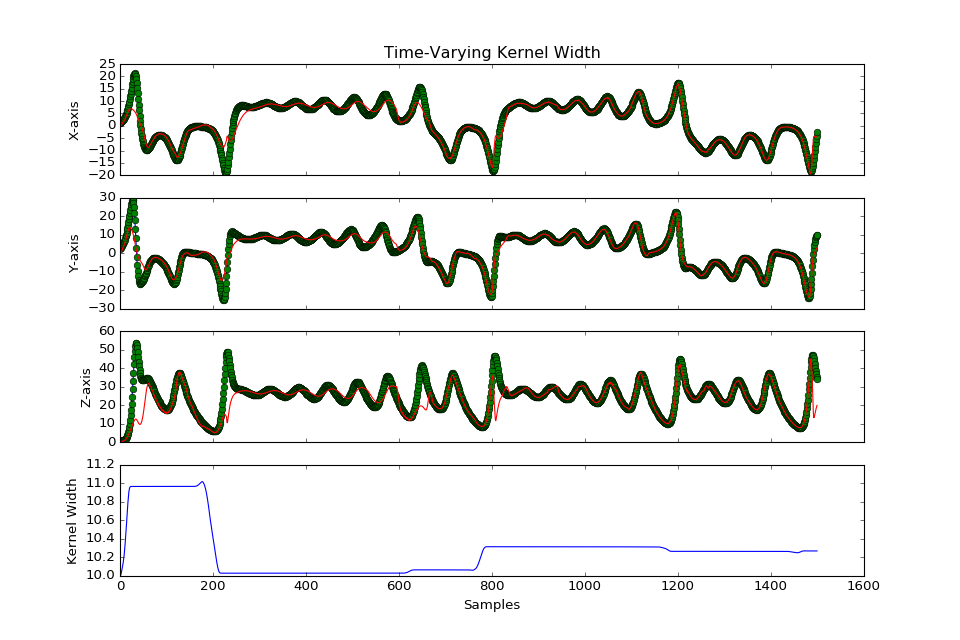

In [13]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(4, sharex=True)
axarr[0].plot(t[0:GraphLim],signal[0][0:GraphLim],'blue', label ="Señal original")    
axarr[0].plot(t[0:GraphLim],noiseSignal[0][0:GraphLim],'go', label ="Muestras")
axarr[0].plot(t[0:GraphLim],filteredSignal[0][0:GraphLim],'red', label ="Filtro")
axarr[0].set_title('Time-Varying Kernel Width')
axarr[0].set_ylabel('X-axis')
#axarr[0].set_xlabel('Muestras')
axarr[1].plot(t[0:GraphLim],signal[1][0:GraphLim],'blue', label ="Señal original")    
axarr[1].plot(t[0:GraphLim],noiseSignal[1][0:GraphLim],'go', label ="Muestras")
axarr[1].plot(t[0:GraphLim],filteredSignal[1][0:GraphLim],'red', label ="Filtro")
axarr[1].set_ylabel('Y-axis')
#axarr[1].set_xlabel('Muestras')
axarr[2].plot(t[0:GraphLim],signal[2][0:GraphLim],'blue', label ="Señal original")    
axarr[2].plot(t[0:GraphLim],noiseSignal[2][0:GraphLim],'go', label ="Muestras")
axarr[2].set_ylabel('Z-axis')
#axarr[2].set_xlabel('Muestras')
axarr[2].plot(t[0:GraphLim],filteredSignal[2][0:GraphLim],'red', label ="Filtro")
axarr[3].plot(t[0:GraphLim],sigmaStory[0:GraphLim])
axarr[3].set_ylabel('Kernel Width')   
axarr[3].set_xlabel('Samples')   

HOLO 8

<IPython.core.display.Javascript object>


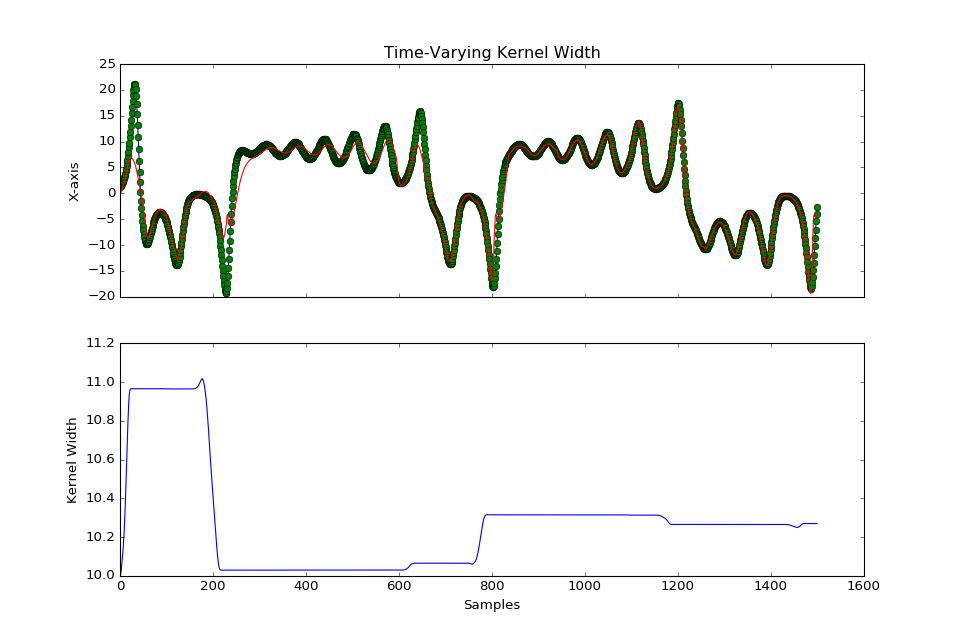

In [14]:
####
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(t[0:GraphLim],signal[0][0:GraphLim],'blue', label ="Señal original")    
axarr[0].plot(t[0:GraphLim],noiseSignal[0][0:GraphLim],'go', label ="Muestras")
axarr[0].plot(t[0:GraphLim],filteredSignal[0][0:GraphLim],'red', label ="Filtro")
axarr[0].set_title('Time-Varying Kernel Width')
axarr[0].set_ylabel('X-axis')
axarr[1].plot(t[0:GraphLim],sigmaStory[0:GraphLim])
axarr[1].set_ylabel('Kernel Width')   
axarr[1].set_xlabel('Samples')   

show()